# Embedding CPLEX in scikit-learn

`scikit-learn` is a widely-used library of Machine-Learning algorithms in Python.

In this notebook, we show how to embed CPLEX as a scikit-learn _transformer_ class.
DOcplex provides transformer classes that take a matrix `X` of constraints and a vector `y` of costs and solves a linear problem using CPLEX.

Transformer classes share a `solve(X, Y, **params)` method which expects:
 - an X matrix containing the constraints of the linear problem
 - a Y vector containing the cost coefficients.
 
The transformer classes accept smatrices invarious formats:

- Python lists
- numpy matrices
- pandas dataframes,
- scipy's sparse matrices (csr, coo, etc...()
 
## DOcplex transformer classes

There are two DOcplex transformer classes:

 - CplexLPTransformer expects to solve a linear problem in the classical form: 
 
 $$ minimize\  C^{t} x\\ s.t.\\ 
 Ax <= B$$
 
 Where $A$ is a (M,N) matrix describing the constraints and $B$ is a scalar vector of size M, containing the _right hand sides_ of the constraints, and $C$ is the _cost vector_ of size N. In this case the transformer expects a (M,N+1) matrix, where the last column contains the right hand sides.
 
 - CplexRangeTransformer expects to solve linear problem as a set of _range_ constraints:
 
  $$ minimize\  C^{t} x\\ s.t.\\ 
 m <= Ax <= M$$
 
  Where $A$ is a (M,N) matrix describing the constraints, $m$ and $M$ are two scalar vectors of size M, containing the _minimum_ and _maximum_ values for the row expressions, and $C$ is the _cost vector_ of size N. In this case the transformer expects a (M,N+2) matrix, where the last two columns contains the minimum and maximum values (in this order).


In [1]:
try:
    import numpy as np
except ImportError:
    raise RuntimError('This notebook requires numpy')

try:
    import pandas as pd
    from pandas import DataFrame 
except ImportError:
    raise RuntimError('This notebook requires pandas (not found)')


In the next section we illustrate the range transformer with the Diet Problem, from DOcplex distributed examples.


## The Diet Problem

The diet problem is delivered in the DOcplex examples.

Given a breakdown matrix of various foods in elementary nutrients, plus limitations on quantities for foods an nutrients, and food costs, the goal is to find the optimal quantity for each food for a balanced diet.

In [2]:
# the baseline diet data as Python lists of tuples.
FOODS = [
    ("Roasted Chicken", 0.84, 0, 10),
    ("Spaghetti W/ Sauce", 0.78, 0, 10),
    ("Tomato,Red,Ripe,Raw", 0.27, 0, 10),
    ("Apple,Raw,W/Skin", .24, 0, 10),
    ("Grapes", 0.32, 0, 10),
    ("Chocolate Chip Cookies", 0.03, 0, 10),
    ("Lowfat Milk", 0.23, 0, 10),
    ("Raisin Brn", 0.34, 0, 10),
    ("Hotdog", 0.31, 0, 10)
]

NUTRIENTS = [
    ("Calories", 2000, 2500),
    ("Calcium", 800, 1600),
    ("Iron", 10, 30),
    ("Vit_A", 5000, 50000),
    ("Dietary_Fiber", 25, 100),
    ("Carbohydrates", 0, 300),
    ("Protein", 50, 100)
]

FOOD_NUTRIENTS = [
    ("Roasted Chicken", 277.4, 21.9, 1.8, 77.4, 0, 0, 42.2),
    ("Spaghetti W/ Sauce", 358.2, 80.2, 2.3, 3055.2, 11.6, 58.3, 8.2),
    ("Tomato,Red,Ripe,Raw", 25.8, 6.2, 0.6, 766.3, 1.4, 5.7, 1),
    ("Apple,Raw,W/Skin", 81.4, 9.7, 0.2, 73.1, 3.7, 21, 0.3),
    ("Grapes", 15.1, 3.4, 0.1, 24, 0.2, 4.1, 0.2),
    ("Chocolate Chip Cookies", 78.1, 6.2, 0.4, 101.8, 0, 9.3, 0.9),
    ("Lowfat Milk", 121.2, 296.7, 0.1, 500.2, 0, 11.7, 8.1),
    ("Raisin Brn", 115.1, 12.9, 16.8, 1250.2, 4, 27.9, 4),
    ("Hotdog", 242.1, 23.5, 2.3, 0, 0, 18, 10.4)
]

In [3]:
nb_foods = len(FOODS)
nb_nutrients = len(NUTRIENTS)
print('#foods={0}'.format(nb_foods))
print('#nutrients={0}'.format(nb_nutrients))

assert nb_foods == len(FOOD_NUTRIENTS)

#foods=9
#nutrients=7


## Using the transformer with a numpy matrix

In this section we show how to package the decision model into a scikit transformer that takes two inputs:

 - a matrix X, usually denoting the Machine-LearningL features, but used here to pass the diet problem data in the form of a nb_nutrients x (nb_foods + 2)) matrix. The structure of this matrix is:
        for each food, the breakdown quantity of nutrient of the food,
        two additional 'min' and 'max' columns contain the range of valid nutrient quantity.

 - a vector Y, here assumed to contain the costs (size is nb_foods)

### Prepare the data as a numpy matrix

In this section we build a numpy matrix to be passed to the transformer.

First, we extract the food to nutrient matrix by stripping the names.

In [4]:
mat_fn = np.matrix([FOOD_NUTRIENTS[f][1:] for f in range(nb_foods)])
print('The food-nutrient matrix has shape: {0}'.format(mat_fn.shape))

The food-nutrient matrix has shape: (9L, 7L)


Then we extract the two vectors of min/max for each nutrient. Each vector has nb_nutrients elements.
We also break the `FOODS` collection of tuples into columns

In [5]:
nutrient_mins = [NUTRIENTS[n][1] for n in range(nb_nutrients)]
nutrient_maxs = [NUTRIENTS[n][2] for n in range(nb_nutrients)]

food_names ,food_costs, food_mins, food_maxs = map(list, zip(*FOODS))

We are now ready to prepare the transformer matrix. This matrix has shape (7, 11) as we
have 7 nutrients and 9 foods, plus the additional `min` and `max` columns

In [6]:
# step 1. add two lines for nutrient mins, maxs
nf2 = np.append(mat_fn, np.matrix([nutrient_mins, nutrient_maxs]), axis=0)
mat_nf = nf2.transpose()

In [7]:
mat_nf.shape

(7L, 11L)

In [8]:
np_costs = np.array(food_costs)

### Using the transformer

To use the transformer, create an instance and pass the follwing parameters to the `transform` method
 - the `X` matrix of size(M, N+2) containing coefficients for N column variables plus two addition column for range mins and maxs.
 - the `Y` cost vector
 
In addition, some data elements that can't be encoded in the matrix itself should be passed as keyword arguments:

- `ubs` denotes the upper bound for the column varuiables that are created. The expected size of this scalar vector is N (when matrix has size (M,N+2))
- `colnames` is a vector of strings, containing names for the column variables (here the food names). The expected size of this vector is N (when matrix has size (M,N+2))

In [9]:
from docplex.mp.sktrans.transformers import *

np_diet = LPRangeTransformer().transform(mat_nf, np_costs, ubs=food_maxs, colnames=food_names).sort_values(by='value', ascending=False)
np_diet

,name,value
1,Chocolate Chip Cookies,10.000000
0,Spaghetti W/ Sauce,2.155172
2,Lowfat Milk,1.831167
3,Hotdog,0.929698


## Using the transformer with a pandas dataframe

In this section we show how to use a transformer with data stored in a pandas dtaframe.
In this case, the row minimum (resp. maximum) values are expected to be stored in column `min` (resp `max`).

### Prepare the data as a pandas dataframe

In this section we build a numpy matrix to be passed to the transformer.

We start by extracting the 'food to nutrient' matrix by stripping the names, then
add the two addition columns for min and max values.

In [10]:
# convert raw data to dataframes
df_foods = DataFrame(FOODS, columns=["food", "cost", "min", "max"])
df_nutrients = DataFrame(NUTRIENTS, columns = ["nutrient", "min", "max"])
fn_columns = ["food"] + df_nutrients["nutrient"].values.tolist()

# food to nutrients matrix
df_fns = DataFrame(FOOD_NUTRIENTS, columns=fn_columns)
df_fns.set_index('food', inplace=True)

# nutrients to foods
scX = df_fns.T
scX.columns = df_foods['food']
# min/max columns
scX['min'] = df_nutrients['min'].tolist()
scX['max'] = df_nutrients['max'].tolist()
scX.head()

food,Roasted Chicken,Spaghetti W/ Sauce,"Tomato,Red,Ripe,Raw","Apple,Raw,W/Skin",Grapes,Chocolate Chip Cookies,Lowfat Milk,Raisin Brn,Hotdog,min,max
Calories,277.4,358.2,25.8,81.4,15.1,78.1,121.2,115.1,242.1,2000,2500
Calcium,21.9,80.2,6.2,9.7,3.4,6.2,296.7,12.9,23.5,800,1600
Iron,1.8,2.3,0.6,0.2,0.1,0.4,0.1,16.8,2.3,10,30
Vit_A,77.4,3055.2,766.3,73.1,24.0,101.8,500.2,1250.2,0.0,5000,50000
Dietary_Fiber,0.0,11.6,1.4,3.7,0.2,0.0,0.0,4.0,0.0,25,100


In [11]:
# the cost vector
scY = df_foods['cost'].copy()
scY.index = df_foods['food']
scY.head()

food
Roasted Chicken        0.84
Spaghetti W/ Sauce     0.78
Tomato,Red,Ripe,Raw    0.27
Apple,Raw,W/Skin       0.24
Grapes                 0.32
Name: cost, dtype: float64

Running the transformer is straightforward. Gaian we pass the upper bound of column variables with the `ubs` keyword arguments, but column names are derived from the dataframe columns, so there is no need to pass a `colnames` argument.

In [12]:
df_diet = LPRangeTransformer().transform(scX, scY, ubs=df_foods['max']).sort_values(by='value', ascending=False)
df_diet


,name,value
1,Chocolate Chip Cookies,10.000000
0,Spaghetti W/ Sauce,2.155172
2,Lowfat Milk,1.831167
3,Hotdog,0.929698


In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

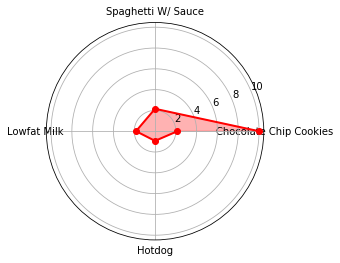

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_radar_chart(labels, stats, **kwargs):
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    # close the plot
    stats  = np.concatenate((stats, [stats[0]]))
    angles = np.concatenate((angles, [angles[0]]))
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats, 'o-', linewidth=2, **kwargs)
    ax.fill(angles, stats, alpha=0.30, **kwargs)
    ax.set_thetagrids(angles * 180/np.pi, labels)
    #ax.set_title([df.loc[386,"Name"]])
    ax.grid(True)
    
plot_radar_chart(labels=df_diet['name'], stats=df_diet['value'], color='r')

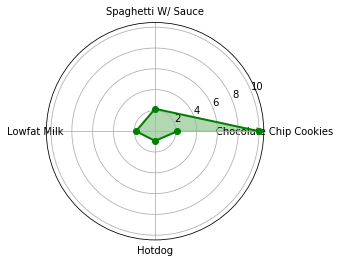

In [15]:
plot_radar_chart(labels=np_diet['name'], stats=np_diet['value'], color='g')

## Using a transformer with scipy's sparse matrices

In this section we show how to use a scipy sparse matrix with a transformer.

As the Diet Problem matrix is not sparse at all, we change to a small (toy) example:

We have N integer variables constrained to be greater than the  previous in the list, and we want to minimize the sum of the last and first variable.

The solution is obvious: the sequence of integers from 1 to N, but let' see how we can implement this with a ScipY csr matrix and solve it with CPLEX.

### Mathematical description of the problem

$$
minimize x_{n} + x_{1}\\
s.t.\\
x_{i+1} >= x_{i} + 1 \forall i\  in\  \{1..N-1\}
$$

### Prepare the csr matrix

the csr matrix (see https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.csr_matrix.html) is built by specifying the value of nonzeros with their row and column indices.

There are $N-1$ constraints of the form $x_{i} - x{i+1} <= -1$ so there are only two non-zero coefficients for row $i$: 

 - 1 at position $(i,i)$
 - -1 at position $(i, i+1)$
 
the _right_hand side_ (rhs for short) is -1 for the first $N-1$ rows, and 0 for the last one.


In [16]:
# N is the size 
N = 11
xs = []
ys = []
for i in range(N - 1):
    xs.append(i)
    ys.append(i)
    xs.append(i)
    ys.append(i + 1)

data = list([1, -1] * (N - 1))

# add an extra column for rhs
# rhs is one column of 1s at the right
xs += list(range(N))
ys += [N] * N
data += [-1] * (N - 1)
data += [0]

In [17]:
try:
    import scipy as sp
except ImportError:
    raise RuntimeError('This notebvook requires SciPy')

# build the CSR matrix from xs, ys, data
spm = sp.sparse.csr_matrix((data, (xs, ys)), shape=(N, N + 1))

The cost vector contains only two nonzeros, the first and last slots

In [18]:
costs = [0] * N
costs[0] = 1
costs[-1] = 1

To run the transformer, we add that column variable have a lower bound of 1 and a n upper bound of 2*N (this is not really necessary).
As expected, the result is the sequence of natural numbers.

In [19]:
from docplex.mp.sktrans.transformers import LPTransformer
res = LPTransformer().transform(spm, costs, ubs=2*N, lbs=1)
res

,value
0,1.0
1,2.0
2,3.0
3,4.0
4,5.0
5,6.0
6,7.0
7,8.0
8,9.0
9,10.0
